**Importing Libraries** 

In [266]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


branca-0.4.1         | 26 KB     | ##################################### | 1

**Reading Postal Codes of Canada from wiki page**

In [303]:
import urllib.request
from bs4 import BeautifulSoup
from urllib.request import urlopen

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = urlopen(url)
soup = BeautifulSoup(html,'html.parser')

table = soup.find_all('table')
tables = table[0]

In [304]:
rows = tables.find_all('tr')


In [305]:
#Fetching PostalCode, Borough and Neighborhood data
PostalCode = []
Borough = []
Neighborhood = []

for row in rows:
    cells = row.find_all('td')
    if len(cells)>1:
        pc = cells[0]
        PostalCode.append (pc.text.strip())
        brgh = cells[1]
        Borough.append(brgh.text.strip())
        ngb = cells[2]
        Neighborhood.append(ngb.text.strip())
            


**Creating empty DataFrame for PostalCode, Borough and Neighborhood**

In [306]:
column_names = ['PostalCode','Borough','Neighborhood']
pd.options.display.max_columns = None
pd.options.display.max_rows = None
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,PostalCode,Borough,Neighborhood


In [307]:
#populating the dataframe
neighborhoods['PostalCode'] = PostalCode
neighborhoods['Borough']= Borough
neighborhoods['Neighborhood'] = Neighborhood

**Dropping rows where Borough is not available**

In [308]:
neighborhoods['Borough'].value_counts()
neighborhood_data = neighborhoods[neighborhoods['Borough']!= 'Not assigned']


**Filling missing Neighborhood data and creating final dataframe**

In [309]:
neighborhood_final = neighborhood_data
neighborhood_final.replace(neighborhood_final['Neighborhood']=='Not assigned',neighborhood_final['Borough'], inplace = True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [310]:
#shape of dataset
print (neighborhood_final.shape)

(103, 3)


**Reading Geospatial Data**

In [311]:
codes = pd.read_csv('http://cocl.us/Geospatial_data')
codes.rename(columns = {'Postal Code':'PostalCode'}, inplace = True)


In [312]:
#merging postalcode datframe with latitude/longitude dataframe
ngh_df = pd.merge(neighborhood_final, codes, on ='PostalCode')
ngh_df.shape

(103, 5)

**Initializing geolocator for Toronto Coordinates**

In [313]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


**Creating Toronto maps using Folium**

In [336]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ngh_df['Latitude'], ngh_df['Longitude'], ngh_df['Borough'], ngh_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Initilizing data items to connect to Foursquare website**

In [315]:
CLIENT_ID = 'EIFWKYFI21DRBHHNMS10RT5LSTRMUTXUSVOSANHGTZH3BNX4' # your Foursquare ID
CLIENT_SECRET = 'BATTX4BZZSVNPRYXIKLVZIMAZ1P01NURQYDGAWNIXIBKRQK4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: EIFWKYFI21DRBHHNMS10RT5LSTRMUTXUSVOSANHGTZH3BNX4
CLIENT_SECRET:BATTX4BZZSVNPRYXIKLVZIMAZ1P01NURQYDGAWNIXIBKRQK4


**Fetching Venue Details from Foursquare website**

In [316]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(ngh_df['Latitude'], ngh_df['Longitude'], ngh_df['PostalCode'], ngh_df['Borough'], ngh_df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


**Arranging Data in Dataframe**

In [317]:
venues_df = pd.DataFrame(venues)
# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
print (venues_df.head())

(2130, 9)
  PostalCode     Borough      Neighborhood  BoroughLatitude  BoroughLongitude                          VenueName  VenueLatitude  VenueLongitude               VenueCategory
0        M3A  North York         Parkwoods        43.753259        -79.329656                    Brookbanks Park      43.751976      -79.332140                        Park
1        M3A  North York         Parkwoods        43.753259        -79.329656                      Variety Store      43.751974      -79.333114           Food & Drink Shop
2        M3A  North York         Parkwoods        43.753259        -79.329656  Corrosion Service Company Limited      43.752432      -79.334661  Construction & Landscaping
3        M4A  North York  Victoria Village        43.725882        -79.315572             Victoria Village Arena      43.723481      -79.315635                Hockey Arena
4        M4A  North York  Victoria Village        43.725882        -79.315572                          Portugril      43.725819   

In [318]:
print('There are {} uniques categories of Venue.'.format(len(venues_df['VenueCategory'].unique())))

There are 272 uniques categories of Venue.


**Picking data for Restaurants only**

In [319]:
rest_df = venues_df[venues_df['VenueCategory'].str.contains('Restaurant')]
rest_df.head()


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
4,M4A,North York,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
14,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
29,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
45,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Izumi,43.649970,-79.360153,Asian Restaurant
50,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Flame Shack,43.656844,-79.358917,Restaurant


**Analyzing data using matplotlib**

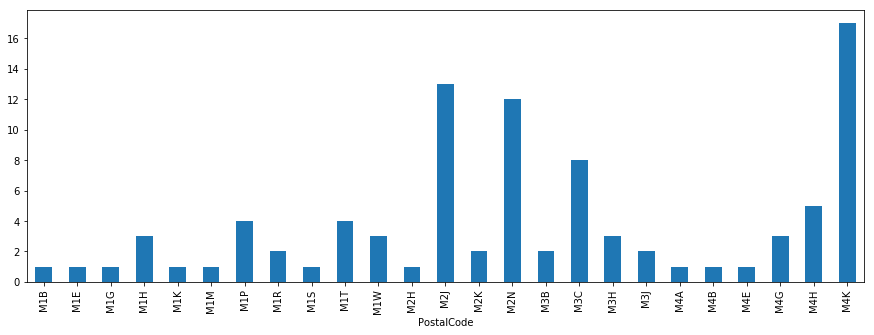

In [357]:
import matplotlib as plt
vc_df = rest_df.groupby('PostalCode')['VenueCategory'].count()[:25]
vc_df.plot(kind = 'bar',figsize = (15,5))
#plt.show()

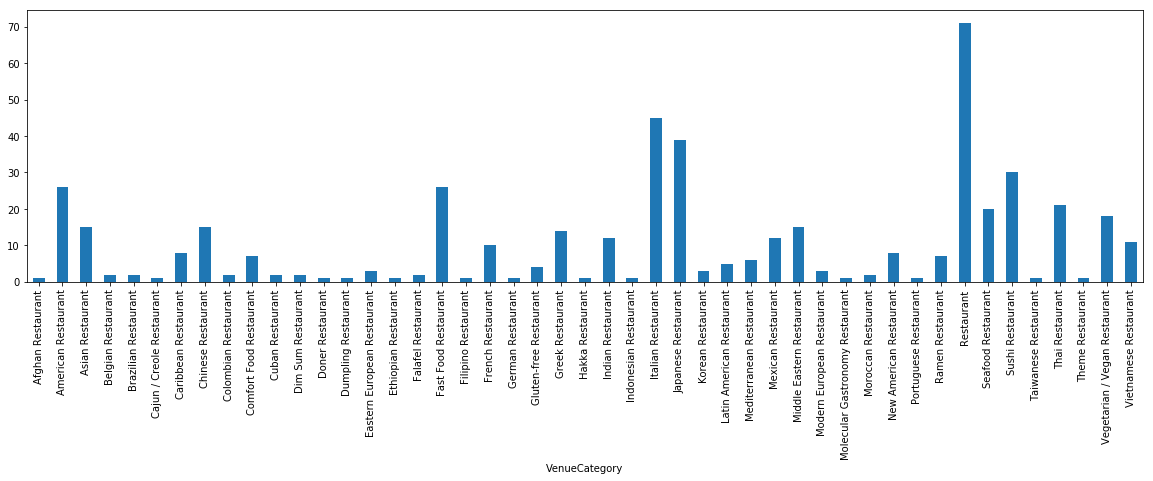

In [355]:
import matplotlib as plt
vc_df = rest_df.groupby('VenueCategory')['VenueCategory'].count()[:50]
vc_df.plot(kind = 'bar', figsize = (20,5))
#plt.show()

In [320]:
#Applying One Hot Encoding to Venue Category column
rest_onehot = pd.get_dummies(rest_df[['VenueCategory']], prefix="", prefix_sep="")

# adding back postal, borough and neighborhood column to dataframe
rest_onehot['PostalCode'] = rest_df['PostalCode'] 
rest_onehot['Borough'] = rest_df['Borough'] 
rest_onehot['Neighborhoods'] = rest_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(rest_onehot.columns[-3:]) + list(rest_onehot.columns[:-3])
rest_onehot = rest_onehot[fixed_columns]
print(rest_onehot.shape)
rest_onehot.head()

(481, 50)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
4,M4A,North York,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,M5A,Downtown Toronto,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


**Applying group by to sum up data by each restaurant type for each postal code**

In [321]:

rest_grouped = rest_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).sum().reset_index()

print(rest_grouped.shape)
rest_grouped.head()

(66, 50)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M1B,Scarborough,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M1G,Scarborough,Woburn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M1H,Scarborough,Cedarbrae,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Creating DataFrame to track top restaurant types across each PostCode**

In [322]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Prioirty'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Prioirty'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
top_restaurant = pd.DataFrame(columns=columns)
top_restaurant['PostalCode'] = toronto_grouped['PostalCode']
top_restaurant['Borough'] = toronto_grouped['Borough']
top_restaurant['Neighborhoods'] = toronto_grouped['Neighborhoods']



In [323]:
for ind in np.arange(rest_grouped.shape[0]):
    row_categories = rest_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    top_restaurant.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

print(top_restaurant.shape)
top_restaurant.head()

(66, 13)


,PostalCode,Borough,Neighborhoods,1st Prioirty,2nd Prioirty,3rd Prioirty,4th Prioirty,5th Prioirty,6th Prioirty,7th Prioirty,8th Prioirty,9th Prioirty,10th Prioirty
0,M1B,Scarborough,"Malvern, Rouge",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",Mexican Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2,M1G,Scarborough,Woburn,Korean Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,M1H,Scarborough,Cedarbrae,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


**Applying KMeans Clustering**

In [324]:
# merging datasets for kmeans clustering to keep only statistical data
rest_inter =  pd.merge(rest_grouped.drop(['Borough','Neighborhoods'], axis = 1),ngh_df.drop(['Borough','Neighborhood'],axis =1) , on ='PostalCode')
rest_clust = rest_inter.drop(['PostalCode'], axis = 1)

# Applying kmeans
cluster_no = 3
kmeans = KMeans(n_clusters=cluster_no,init='k-means++', n_init=10).fit(rest_clust)
labels = kmeans.labels_
toronto_restaurant_df=[]
toronto_restaurant_df = rest_grouped.iloc[:,0:3]
toronto_restaurant_df['ClusterCategory'] = labels
#toronto_restaurant_df.head()
#rest_df.head()

**Merging Datasets to bring cluster label, Latitude & Logitude, Top 10 restaurant types**

In [325]:
tp_rest = top_restaurant.drop(["Borough", "Neighborhoods"], axis = 1)
restaurant_cluster = pd.merge(toronto_restaurant_df,tp_rest , on ='PostalCode')
restaurant_cluster_final = pd.merge(restaurant_cluster,ngh_df.drop(['Borough','Neighborhood'],axis =1) , on ='PostalCode')
print(restaurant_cluster_final.shape)
restaurant_cluster_final.head()

(66, 16)


,PostalCode,Borough,Neighborhoods,ClusterCategory,1st Prioirty,2nd Prioirty,3rd Prioirty,4th Prioirty,5th Prioirty,6th Prioirty,7th Prioirty,8th Prioirty,9th Prioirty,10th Prioirty,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",1,Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,43.806686,-79.194353
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",1,Mexican Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.763573,-79.188711
2,M1G,Scarborough,Woburn,1,Korean Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.770992,-79.216917
3,M1H,Scarborough,Cedarbrae,1,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,43.773136,-79.239476
4,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",1,Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.727929,-79.262029


In [326]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(cluster_no)
ys = [i+x+(i*x)**2 for i in range(cluster_no)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(restaurant_cluster_final['Latitude'], restaurant_cluster_final['Longitude'], restaurant_cluster_final['PostalCode'], restaurant_cluster_final['Borough'], restaurant_cluster_final['Neighborhoods'], restaurant_cluster_final['ClusterCategory']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


**Analyzing each Cluster**

In [333]:
restaurant_cluster_final['ClusterCategory'].value_counts()

1    44
0    16
2     6
Name: ClusterCategory, dtype: int64

In [328]:
restaurant_cluster_final[restaurant_cluster_final['ClusterCategory']==0]
#cluster 0 consists mainly of Italian, Sushi and Japanese restaurant


,PostalCode,Borough,Neighborhoods,ClusterCategory,1st Prioirty,2nd Prioirty,3rd Prioirty,4th Prioirty,5th Prioirty,6th Prioirty,7th Prioirty,8th Prioirty,9th Prioirty,10th Prioirty,Latitude,Longitude
12,M2J,North York,"Fairview, Henry Farm, Oriole",0,Fast Food Restaurant,Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,French Restaurant,Filipino Restaurant,43.778517,-79.346556
14,M2N,North York,"Willowdale, Willowdale East",0,Ramen Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Indonesian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Cuban Restaurant,Falafel Restaurant,43.770120,-79.408493
16,M3C,North York,Don Mills,0,Asian Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Dumpling Restaurant,French Restaurant,Filipino Restaurant,43.725900,-79.340923
24,M4K,East Toronto,"The Danforth West, Riverdale",0,Greek Restaurant,Italian Restaurant,Restaurant,American Restaurant,Indian Restaurant,Caribbean Restaurant,Japanese Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Filipino Restaurant,43.679557,-79.352188
28,M4S,Central Toronto,Davisville,0,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Greek Restaurant,Seafood Restaurant,Restaurant,Indian Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Fast Food Restaurant,43.704324,-79.388790
31,M4X,Downtown Toronto,"St. James Town, Cabbagetown",0,Restaurant,Italian Restaurant,American Restaurant,Thai Restaurant,Taiwanese Restaurant,Indian Restaurant,Caribbean Restaurant,Chinese Restaurant,Japanese Restaurant,Vietnamese Restaurant,43.667967,-79.367675
32,M4Y,Downtown Toronto,Church and Wellesley,0,Sushi Restaurant,Japanese Restaurant,Restaurant,Mediterranean Restaurant,Afghan Restaurant,Caribbean Restaurant,Indian Restaurant,Mexican Restaurant,Fast Food Restaurant,American Restaurant,43.665860,-79.383160
34,M5B,Downtown Toronto,"Garden District, Ryerson",0,Middle Eastern Restaurant,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Ramen Restaurant,New American Restaurant,Ethiopian Restaurant,Chinese Restaurant,Mexican Restaurant,Modern European Restaurant,43.657162,-79.378937
36,M5E,Downtown Toronto,Berczy Park,0,Seafood Restaurant,Restaurant,Thai Restaurant,Greek Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Japanese Restaurant,French Restaurant,Comfort Food Restaurant,43.644771,-79.373306
37,M5G,Downtown Toronto,Central Bay Street,0,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant,Modern European Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Korean Restaurant,Falafel Restaurant,43.657952,-79.387383


In [329]:
restaurant_cluster_final[restaurant_cluster_final['ClusterCategory']==1]
#cluster 1 consists mainly of Vietnamese, Indiana and Chinese

,PostalCode,Borough,Neighborhoods,ClusterCategory,1st Prioirty,2nd Prioirty,3rd Prioirty,4th Prioirty,5th Prioirty,6th Prioirty,7th Prioirty,8th Prioirty,9th Prioirty,10th Prioirty,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",1,Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,43.806686,-79.194353
1,M1E,Scarborough,"Guildwood, Morningside, West Hill",1,Mexican Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.763573,-79.188711
2,M1G,Scarborough,Woburn,1,Korean Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.770992,-79.216917
3,M1H,Scarborough,Cedarbrae,1,Hakka Restaurant,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,43.773136,-79.239476
4,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",1,Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.727929,-79.262029
5,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",1,American Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.716316,-79.239476
6,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",1,Indian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,43.757410,-79.273304
7,M1R,Scarborough,"Wexford, Maryvale",1,Middle Eastern Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.750072,-79.295849
8,M1S,Scarborough,Agincourt,1,Latin American Restaurant,Vietnamese Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,43.794200,-79.262029
9,M1T,Scarborough,"Clarks Corners, Tam O'Shanter, Sullivan",1,Thai Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,43.781638,-79.304302


In [358]:
restaurant_cluster_final[restaurant_cluster_final['ClusterCategory']==2]
#cluster 0 consists mainly of American

,PostalCode,Borough,Neighborhoods,ClusterCategory,1st Prioirty,2nd Prioirty,3rd Prioirty,4th Prioirty,5th Prioirty,6th Prioirty,7th Prioirty,8th Prioirty,9th Prioirty,10th Prioirty,Latitude,Longitude
35,M5C,Downtown Toronto,St. James Town,2,American Restaurant,Restaurant,Italian Restaurant,Moroccan Restaurant,Japanese Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,Middle Eastern Restaurant,French Restaurant,43.651494,-79.375418
38,M5H,Downtown Toronto,"Richmond, Adelaide, King",2,Restaurant,Thai Restaurant,Sushi Restaurant,New American Restaurant,Gluten-free Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Colombian Restaurant,Fast Food Restaurant,43.650571,-79.384568
40,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",2,Restaurant,Japanese Restaurant,American Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,New American Restaurant,Fast Food Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,43.647177,-79.381576
41,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",2,Restaurant,American Restaurant,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,New American Restaurant,Fast Food Restaurant,43.648198,-79.379817
47,M5W,Downtown Toronto,Stn A PO Boxes,2,Japanese Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant,Molecular Gastronomy Restaurant,Eastern European Restaurant,French Restaurant,Sushi Restaurant,43.646435,-79.374846
48,M5X,Downtown Toronto,"First Canadian Place, Underground city",2,Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Seafood Restaurant,Thai Restaurant,Sushi Restaurant,Gluten-free Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,43.648429,-79.382280


**End of Code**